In [59]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as const
import astropy.visualization
astropy.visualization.quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x199c670f9e8>

## Calculate results of Petschek reconnection

In [10]:
# Constants
mu_0 = const.mu0                # Magnetic constant
m_p = const.m_p                 # Proton mass
m_si = 4.6636*10**(-26)*u.kg    # Atomic mass silicon
k_B = const.k_B                 # Boltzmann constant


# Parameters
zeta = 30*u.deg         # Angle of initial field lines
gamma = 5/3             # Ratio of specific heats

# Internal properties
# B_i = 1
# rho_i = 1
# p_i = 1

# External properties
B_e = 1.5*u.mT
n_e = 3e14*u.m**(-3)    # Proton number density
rho_e = m_p * n_e
# p_e = 1
T_e = 2*u.MK
v_ae = (B_e/np.sqrt(mu_0 * rho_e)).to(u.km/u.s)
TA_e = ((m_p/k_B) * (v_ae**2)/2).to(u.MK)
beta_e = T_e/TA_e

# Section 1
rho_1 = rho_e
# p_1 = p_e
v_x1 = 0
v_z1 = 0

# Section 2
rho_2 = rho_1
# p_2 = p_1
v_x2 = -2 * v_ae * np.sin(zeta/2)**2
v_z2 = -v_ae * np.sin(zeta)

# GDS properties
M_2 = np.sqrt(8/(gamma * beta_e)) * np.sin(zeta/2)**2
v_s = np.abs(v_x2) * (np.sqrt(M_2**(-2) + ((gamma + 1)**2)/16) - (3 - gamma)/4)

# Section 3
beta_3 = beta_e * (1 + gamma * M_2**2 * (1 + v_s/np.abs(v_x2)))
rho_3 = rho_2 * (1 + (np.abs(v_x2)/v_s))
T_3 = TA_e * beta_3 * rho_e/rho_3
v_x3 = 0
v_z3 = v_z2

## Spectral Synthesis

In [69]:
# Create masks for sections 2 and 3 separated by shocks.

t = 1*u.s   # Time that has passed (arbitrary)
v_xae = v_ae * np.cos(zeta)
v_zae = -v_ae * np.sin(zeta)
phi = (np.arctan(v_s/np.abs(v_zae))).to(u.deg)

nx = 200
nz = 200
x = np.linspace(-t * v_xae, t * v_xae, num=nx)
z = np.linspace(t * v_zae, -t * v_zae, num=nz)
xv, zv = np.meshgrid(x, z)

z1 = xv * np.tan(zeta)
z2 = xv * np.tan(90*u.deg - phi)
mask_2 = np.zeros((nx, nz))
mask_2[np.logical_and(np.abs(z1) < np.abs(zv), np.abs(zv) < np.abs(z2))] = 1

mask_3 = np.zeros((nx, nz))
mask_3[np.abs(zv) > np.abs(z2)] = 1

# Plot masks
plt.imshow(mask_2, extent=[x.min().value, x.max().value, z.min().value, z.max().value])
plt.figure()
plt.imshow(mask_3, extent=[x.min().value, x.max().value, z.min().value, z.max().value])

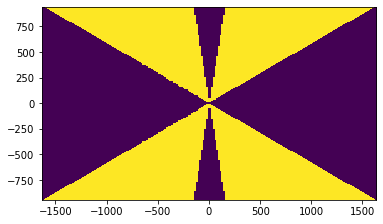

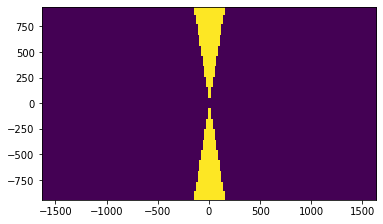

In [27]:
amp = 1
peak = v_z3
v_range = np.linspace(peak - (200*u.km/u.s), -peak + (200*u.km/u.s), num=200)
v_th = (np.sqrt(k_B * T_3/m_si)).to(u.km/u.s)   # Thermal speed (for Silicon)
th_brd_lo = amp * np.exp(-((v_range - peak)**2)/(2 * v_th**2))
th_brd_hi = amp * np.exp(-((v_range + peak)**2)/(2 * v_th**2))
th_brd = th_brd_lo + th_brd_hi

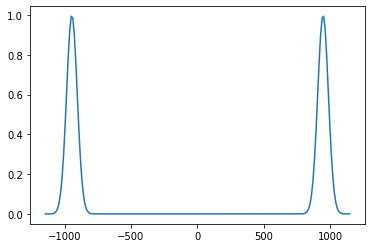

In [28]:
plt.plot(v_range, th_brd)